In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import pickle
import jax
import jax.numpy as jnp
import bayes3d as b
import genjax
import matplotlib.pyplot as plt

In [3]:
console = genjax.console(enforce_checkify=True)

In [4]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
NEAR = 0.1
FAR = 5.0

In [6]:
with open('../data.pkl', 'rb') as f:
    data = pickle.load(f)

camera_image_1 = data["init"][0]
categories_on_table = data["init"][1]
target_category = data["init"][2]
table_info = data["init"][3] # table pose and dimensions
n_objects = 5

X_WT = b.t3d.pybullet_pose_to_transform(table_info[0])
X_WC = b.t3d.pybullet_pose_to_transform(camera_image_1["camera_pose"])
X_CT = b.t3d.inverse_pose(X_WC) @ X_WT

def image_to_rgbd(camera_image_1):
    K = camera_image_1['camera_matrix']
    rgb = camera_image_1['rgbPixels']
    depth = camera_image_1['depthPixels']
    camera_pose = camera_image_1['camera_pose']
    camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
    fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
    h,w = depth.shape
    rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,NEAR,FAR))
    return rgbd_original

rgbd_original = image_to_rgbd(camera_image_1)
print("Got rgbd_original")

scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)
print("Got rgb immage scaled down.")

b.setup_renderer(rgbd_scaled_down.intrinsics)

# os.path.join(os.path.abspath(''), 'bayes3d/assets/bop/ycbv/models')# 
model_dir = os.path.join(os.path.abspath('../..'), 'bayes3d/assets/bop/ycbv/models')
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
ycb_filenames = glob.glob(os.path.join(model_dir, "*.ply"))
ycb_index_order = [int(s.split("/")[-1].split("_")[-1].split(".")[0]) for s in ycb_filenames]
sorted_ycb_filenames = [s for _,s in sorted(zip(ycb_index_order, ycb_filenames))]

relevant_objects = [any(x in name for x in categories_on_table) for (i, name) in enumerate(b.utils.ycb_loader.MODEL_NAMES)]
relevant_object_names = [b.utils.ycb_loader.MODEL_NAMES[i] for i in range(len(b.utils.ycb_loader.MODEL_NAMES)) if relevant_objects[i]]
filtered_filenames = [sorted_ycb_filenames[i] for i in range(len(sorted_ycb_filenames)) if relevant_objects[i]]

table_dims = table_info[1:]
table_mesh = b.utils.make_cuboid_mesh(table_dims)
b.RENDERER.add_mesh(table_mesh, "table")
print("Added table mesh.")

pillar_mesh = b.utils.make_cuboid_mesh(jnp.array([0.02, 0.02, 0.5]))
b.RENDERER.add_mesh(pillar_mesh, "pillar")
print("Added pillar mesh.")

for model_path in filtered_filenames:
    b.RENDERER.add_mesh_from_file(model_path, scaling_factor=1.0/1000.0)
    print(f"Added mesh at path {model_path}.")

Got rgbd_original
Got rgb immage scaled down.


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)
Added table mesh.
Added pillar mesh.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000002.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000003.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000011.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000013.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000021.ply.


### Load model

In [7]:
from src.old_models.model2 import model, viz_trace_meshcat

In [8]:
def flat_choicemaps_to_vector_choicemap(choicemaps):
    cm = genjax.choice_map({
        k : jnp.array([c.get_submap(k).get_value() for c in choicemaps])
        for (k, _) in choicemaps[0].get_submaps_shallow()
    })
    return cm

cm = flat_choicemaps_to_vector_choicemap([
    genjax.choice_map({"a": jnp.array([3, 2]), "b": jnp.array([1, 0])}),
    genjax.choice_map({"a": jnp.array([5, 4]), "b": jnp.array([3, 2])}),
])
console.print(cm)

(HierarchicalChoiceMap)
├── :a
│   └── (ValueChoice)
│       └──  i32[2,2]
└── :b
    └── (ValueChoice)
        └──  i32[2,2]

In [9]:
obs_img = b.unproject_depth_jit(
        rgbd_scaled_down.depth,
        rgbd_scaled_down.intrinsics
    )

In [10]:
rgbd_scaled_down.intrinsics.near

0.1

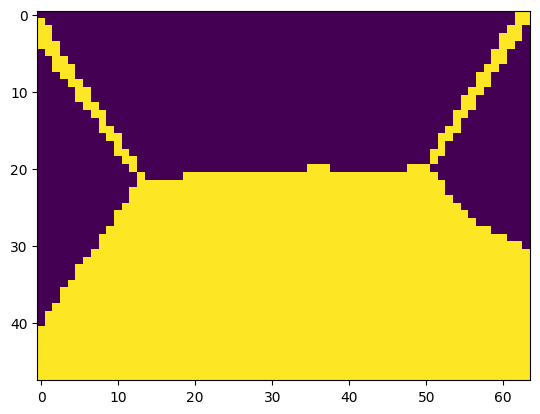

In [11]:
plt.imshow((rgbd_scaled_down.depth < rgbd_scaled_down.intrinsics.far) )

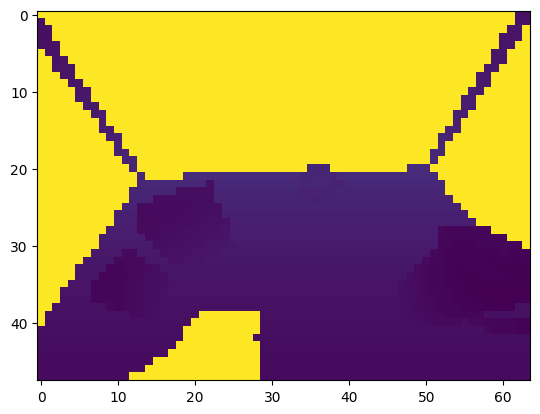

In [12]:
plt.imshow(obs_img[..., 2])

In [13]:
table_choicemap = genjax.choice_map({
                    "root_pose": X_CT,
                    "category_index": 0,
                    "parent_obj": -1,
                    "face_parent": 2,
                    "face_child": 3,
                    "contact_params": jnp.zeros(3)
                })
def obj_choicemap(category_idx):
    return genjax.choice_map({
        "root_pose": jnp.eye(4),
        "category_index": category_idx,
        "parent_obj": 0,
        "face_parent": 2,
        "face_child": 3,
        "contact_params": jnp.zeros(3)
    })

max_n_objects = 8
# Initialize the trace with the table, and all
# the other objects initialized to be on the table
# with the identity pose.
map_choicemap = genjax.indexed_choice_map(
            jnp.arange(max_n_objects),
            flat_choicemaps_to_vector_choicemap([
                table_choicemap,
                *[obj_choicemap(i) for i in [
                    2, 4, 3, 5, 1, 1, 6
                ]]
            ])
        )
constraints = genjax.choice_map({
    "camera_pose": jnp.eye(4),
    "image": b.unproject_depth_jit(
        rgbd_scaled_down.depth,
        rgbd_scaled_down.intrinsics
    ),
    "objects": map_choicemap,
    "variance": 0.02,
    "outlier_prob": 0.0005
})
console.print(constraints)

(HierarchicalChoiceMap)
├── :camera_pose
│   └── (ValueChoice)
│       └──  f32[4,4]
├── :image
│   └── (ValueChoice)
│       └──  f32[48,64,3]
├── :objects
│   └── (IndexedChoiceMap,  i32[8])
│       └── (HierarchicalChoiceMap)
│           ├── :root_pose
│           │   └── (ValueChoice)
│           │       └──  f32[8,4,4]
│           ├── :category_index
│           │   └── (ValueChoice)
│           │       └──  i32[8]
│           ├── :parent_obj
│           │   └── (ValueChoice)
│           │       └──  i32[8]
│           ├── :face_parent
│           │   └── (ValueChoice)
│           │       └──  i32[8]
│           ├── :face_child
│           │   └── (ValueChoice)
│           │       └──  i32[8]
│           └── :contact_params
│               └── (ValueChoice)
│                   └──  f32[8,3]
├── :variance
│   └── (ValueChoice)
│       └── (const) 0.02
└── :outlier_prob
    └── (ValueChoice)
        └── (const) 0.0005

In [14]:
model_args = (
    jnp.arange(max_n_objects), # max_n_objects_array
    1,               # n_objects
    # possible_object_indices
    jnp.arange(len(b.RENDERER.meshes)),
    # pose_bounds
    jnp.array([-jnp.ones(3)*5.0, jnp.ones(3)*5.0]),
    # contact_bounds
    jnp.array([jnp.array([-1., -1., -jnp.pi]), jnp.array([1., 1., jnp.pi])]),
    # all_box_dims
    b.RENDERER.model_box_dims
)

In [15]:
key = jax.random.PRNGKey(0)

In [16]:
subkey, key = jax.random.split(key)
tr1, w1 = model.importance(subkey, constraints, model_args)
viz_trace_meshcat(tr1)

Calling renderer...


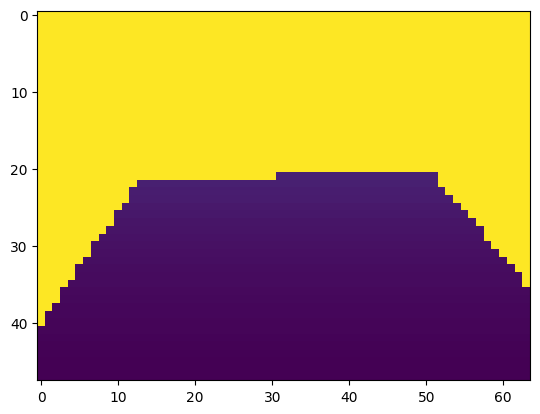

In [17]:
plt.imshow(tr1.get_retval().rendered[:, :, 2])

In [18]:
from genjax import Diff, NoChange, UnknownChange

In [19]:
def update_choicemap(obj_idx, cat_idx):
    return genjax.choice_map({
        "objects": genjax.indexed_choice_map(
            jnp.array([obj_idx]),
            flat_choicemaps_to_vector_choicemap([obj_choicemap(cat_idx)])
        )
    })

In [20]:
def add_object(tr, cat_idx):
    n_objects = tr.get_args()[1]
    nochange_args = tuple(map(lambda v: Diff(v, NoChange), tr.get_args()))
    new_args = (nochange_args[0], Diff(n_objects+1, UnknownChange), *nochange_args[2:])
    newtr, _, _, _ = tr.update(
        key,
        update_choicemap(n_objects, cat_idx),
        new_args)
    return newtr

In [21]:
viz_trace_meshcat(add_object(tr1, 3))

Calling renderer...


### Inference

In [22]:
grid_params = [
    (0.65, jnp.pi, (30,30,15)),
    (0.2, jnp.pi, (15,15,15)),
    (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi, (15,15,15)),
    (0.02, jnp.pi, (9,9,51)),
    (0.01, jnp.pi/5, (15, 15, 15))
]

contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

def cp_choicemap(object_idx, v):
    return genjax.choice_map({
            "objects": genjax.indexed_choice_map(
                jnp.array([object_idx]),
                flat_choicemaps_to_vector_choicemap([genjax.choice_map({"contact_params": v})])
            )
        })
def _c2f(key, tr, object_idx, contact_param_gridding_schedule):
    updater = jax.jit(jax.vmap(lambda trace, v: trace.update(
        key, cp_choicemap(object_idx, v)
    )[0].get_score(), in_axes=(None, 0)))
    cp = tr.get_retval().object_info.params[object_idx, ...]
    for cp_grid in contact_param_gridding_schedule:
        cps = cp + cp_grid
        scores = updater(tr, cps)
        cp = cps[jnp.argmax(scores)]
        # i = jax.random.randint(key, (1,), 0, len(scores))[0]
        # cp = cps[i]
    potential_trace = tr.update(key, cp_choicemap(object_idx, cp))[0]
    return potential_trace

c2f = jax.jit(_c2f)

In [23]:
def _extend_then_c2f(key, tr, cat_idx, contact_param_gridding_schedule):
    return c2f(
        key,
        add_object(tr, cat_idx),
        tr.get_args()[1],
        contact_param_gridding_schedule
    )
extend_then_c2f = jax.jit(_extend_then_c2f)

In [24]:
key, _ = jax.random.split(key)
tr2 = extend_then_c2f(key, tr1, 4, contact_param_gridding_schedule)

Calling renderer...
Calling renderer...
Calling renderer...
Calling renderer...
Calling renderer...


In [25]:
viz_trace_meshcat(tr2)

Now, starting from tr1, try fitting all objects in sequence:

In [26]:
trs = [tr1]
for i in [2, 4, 3, 5, 1, 1]:
    key, _ = jax.random.split(key)
    trs.append(extend_then_c2f(key, trs[-1], i, contact_param_gridding_schedule))
viz_trace_meshcat(trs[-1])

### inference variant without knowledge of object classes

In [27]:
def extend_c2f_all_categories(key, tr, contact_param_gridding_schedule):
    indices = jnp.arange(len(b.RENDERER.meshes))
    keys = jax.random.split(key, len(indices))
    potential_trs = [extend_then_c2f(key, tr, idx, contact_param_gridding_schedule) for (key, idx) in zip(keys, indices)]
    scores = jnp.array([t.get_score() for t in potential_trs])
    best_idx = jnp.argmax(scores)
    return potential_trs[best_idx]

In [28]:
tr2 = extend_c2f_all_categories(key, tr1, contact_param_gridding_schedule)

Calling renderer...


In [29]:
viz_trace_meshcat(tr2)

In [30]:
def extend_c2f_all_categories_n_times(key, tr, contact_param_gridding_schedule, n):
    for _ in range(n):
        tr = extend_c2f_all_categories(key, tr, contact_param_gridding_schedule)
    return tr

In [31]:
tr_ = extend_c2f_all_categories_n_times(key, tr1, contact_param_gridding_schedule, 5)

In [32]:
viz_trace_meshcat(tr_)

In [33]:
def fit_objects_until_convergence(key, tr, contact_param_gridding_schedule, eps=0.1, max_iter=10):
    old_score = -jnp.inf
    new_score = tr.project(genjax.select("image"))
    i = 1
    print("Adding first object...")
    while new_score > old_score + eps and i < max_iter:
        newtr = extend_c2f_all_categories(key, tr, contact_param_gridding_schedule)
        old_score = new_score
        new_score = newtr.project(genjax.select("image"))
        if new_score > old_score + eps:
            tr = newtr
        print(f"Added object {i}.  Image score = {new_score}.")
        i += 1
    return tr

In [39]:
tr_ = fit_objects_until_convergence(key, tr1, contact_param_gridding_schedule)

Adding first object...
Added object 1.  Image score = 42.366539001464844.
Added object 2.  Image score = 43.42448043823242.
Added object 3.  Image score = 44.124351501464844.
Added object 4.  Image score = 44.677734375.
Added object 5.  Image score = 45.27994918823242.
Added object 6.  Image score = 45.42643356323242.
Added object 7.  Image score = 45.52408981323242.


In [40]:
viz_trace_meshcat(tr_)

### Attempt at a VMAP version

Hmm, but apparently the nvdiffrast renderer doesn't support vmap over object identity, so this may be causing the problem.  (Though it looks like the problem actually first occurs in scene graph math, so maybe it's something else.)

In [36]:
def cp_catidx_choicemap(object_idx, cat_idx, v):
    return genjax.choice_map({
            "objects": genjax.indexed_choice_map(
                jnp.array([object_idx]),
                flat_choicemaps_to_vector_choicemap([genjax.choice_map({
                    "contact_params": v,
                    "category_index": cat_idx
                })])
            )
        })
def _c2f_given_cat(key, tr, object_idx, cat_idx, contact_param_gridding_schedule):
    tr = add_object(tr, cat_idx)
    updater = jax.jit(jax.vmap(lambda trace, v: trace.update(
        key, cp_choicemap(object_idx, v)
    )[0].get_score(), in_axes=(None, 0)))
    cp = tr.get_retval().object_info.params[object_idx, ...]
    for cp_grid in contact_param_gridding_schedule:
        cps = cp + cp_grid
        scores = updater(tr, cps)
        cp = cps[jnp.argmax(scores)]
        # i = jax.random.randint(key, (1,), 0, len(scores))[0]
        # cp = cps[i]
    potential_trace = tr.update(key, cp_choicemap(object_idx, cp))[0]
    return potential_trace
c2f_given_cat = jax.jit(_c2f_given_cat)

__c2f_and_catsearch = jax.vmap(c2f_given_cat, in_axes=(None, None, None, 0, None))
def _c2f_and_catsearch(key, tr, object_idx, contact_param_gridding_schedule):
    trs = __c2f_and_catsearch(
        key, tr, object_idx,
        jnp.arange(len(b.RENDERER.meshes)),
        contact_param_gridding_schedule
    )
    scores = jax.vmap(lambda tr: tr.get_score())(trs)
    best_idx = scores.argmax()
    return jax.tree_util.tree_map(lambda x: x[best_idx], trs)

c2f_and_catsearch = jax.jit(_c2f_and_catsearch)

In [37]:
indices = jnp.array([2, 3])
trs = jax.vmap(add_object, in_axes=(None, 0))(tr1, indices)

Calling renderer...


ValueError: Poses Original Shape: (2, 1, 8, 4, 4) Poses Shape:  (2, 8, 4, 4) Indices Shape: (2, 8)

In [ ]:
n_objects = tr1.get_args()[1]
nochange_args = tuple(map(lambda v: Diff(v, NoChange), tr1.get_args()))
new_args = (nochange_args[0], Diff(n_objects+1, UnknownChange), *nochange_args[2:])
def get_newtr(cat_idx):
    newtr, _, _, _ = tr1.update(
        key,
        update_choicemap(n_objects, cat_idx),
        new_args)
    return newtr
newtrs = jax.vmap(get_newtr)(indices)

ValueError: Poses Original Shape: (2, 1, 8, 4, 4) Poses Shape:  (2, 8, 4, 4) Indices Shape: (2, 8)

In [ ]:
console.print(jax.vmap(update_choicemap, in_axes=(None, 0))(2, indices))

(HierarchicalChoiceMap)
└── :objects
    └── (IndexedChoiceMap,  i32[2,1])
        └── (HierarchicalChoiceMap)
            ├── :root_pose
            │   └── (ValueChoice)
            │       └──  f32[2,1,4,4]
            ├── :category_index
            │   └── (ValueChoice)
            │       └──  i32[2,1]
            ├── :contact_params
            │   └── (ValueChoice)
            │       └──  f32[2,1,3]
            ├── :face_child
            │   └── (ValueChoice)
            │       └──  i32[2,1]
            ├── :face_parent
            │   └── (ValueChoice)
            │       └──  i32[2,1]
            └── :parent_obj
                └── (ValueChoice)
                    └──  i32[2,1]

In [ ]:
console.print(update_choicemap(2, indices[0]))

(HierarchicalChoiceMap)
└── :objects
    └── (IndexedChoiceMap,  i32[1])
        └── (HierarchicalChoiceMap)
            ├── :root_pose
            │   └── (ValueChoice)
            │       └──  f32[1,4,4]
            ├── :category_index
            │   └── (ValueChoice)
            │       └──  i32[1]
            ├── :parent_obj
            │   └── (ValueChoice)
            │       └──  i32[1]
            ├── :face_parent
            │   └── (ValueChoice)
            │       └──  i32[1]
            ├── :face_child
            │   └── (ValueChoice)
            │       └──  i32[1]
            └── :contact_params
                └── (ValueChoice)
                    └──  f32[1,3]

In [ ]:
tr2 = c2f_given_cat(key, tr1, 1, 2, contact_param_gridding_schedule)

In [ ]:
viz_trace_meshcat(tr2)

In [ ]:
potential_traces = __c2f_and_catsearch(key, tr1, 1, jnp.array([2, 3]), contact_param_gridding_schedule)

ValueError: Poses Original Shape: (2, 1, 8, 4, 4) Poses Shape:  (2, 8, 4, 4) Indices Shape: (2, 8)

In [ ]:
tr2 = c2f_and_catsearch(key, tr1, 1, contact_param_gridding_schedule)

ValueError: Poses Original Shape: (7, 1, 8, 4, 4) Poses Shape:  (7, 8, 4, 4) Indices Shape: (7, 8)

In [ ]:
viz_trace_meshcat

---

In [ ]:
tr = tr2
object_idx = 1
updater = jax.vmap(lambda trace, v: trace.update(
        key, cp_choicemap(object_idx, v)
    )[0].get_score(), in_axes=(None, 0))
cp = tr.get_retval().object_info.params[object_idx, ...]
cp_grid = contact_param_gridding_schedule[0]
cps = cp + cp_grid
scores = updater(tr, cps)

In [ ]:
key, _ = jax.random.split(key)
i = jax.random.randint(key, (1,), 0, len(scores))[0]
cp = cps[i]
new_tr = tr.update(key, cp_choicemap(object_idx, cp))[0]
viz_trace_meshcat(new_tr)

In [ ]:
# check = jnp.array([False, False, True, True])
check = jnp.array([0., 0., 1., 1.])
vals = jnp.ones(4) * -jnp.inf
check * vals

Array([ nan,  nan, -inf, -inf], dtype=float32)

In [ ]:
tr2.get_score()

Array(-27.04225, dtype=float32)

In [ ]:
viz_trace_meshcat(tr2)

In [ ]:
console.print(cp_choicemap(object_idx, cps[0]))

(HierarchicalChoiceMap)
└── :objects
    └── (IndexedChoiceMap,  i32[1])
        └── (HierarchicalChoiceMap)
            └── :contact_params
                └── (ValueChoice)
                    └──  f32[1,3]

---

In [ ]:
tr2 = add_object(tr1, 2)
viz_trace_meshcat(tr2)

In [ ]:
tr = tr2
object_idx = 1
updater = jax.vmap(lambda trace, v: trace.update(
        key, cp_choicemap(object_idx, v)
    )[0].get_score(), in_axes=(None, 0))
cp = tr.get_retval().object_info.params[object_idx, ...]
cp_grid = contact_param_gridding_schedule[0]
cps = cp + cp_grid
scores = updater(tr, cps)

In [ ]:
trs = jax.vmap(lambda v: tr.update(key, cp_choicemap(object_idx, v))[0], in_axes=(0))(cps)

In [ ]:
console.print(jnp.min(trs.get_subtrace("image").get_score()))
console.print(jnp.max(trs.get_subtrace("image").get_score()))

8.1720376e-05

8.672026e-05

In [ ]:
tr_ = jax.tree_util.tree_map(lambda x: x[4000], trs)
viz_trace_meshcat(tr_)

In [ ]:
cps[0]

Array([-0.65     , -0.65     , -3.1415927], dtype=float32)

In [ ]:
cps[:, 2]

Array([-3.1415927, -2.6927936, -2.243995 , ...,  2.2439952,  2.692794 ,
        3.1415927], dtype=float32)

In [ ]:
tr = tr2
u = lambda v: tr.update(
        key, cp_choicemap(object_idx, v)
    )[0]
ju = u
console.print([ju(cps[i]).get_score() for i in range(3)])
trs = jax.vmap(ju, in_axes=(0,))(cps[:3])
console.print(trs.get_score())

[Array(-inf, dtype=float32), Array(-inf, dtype=float32), Array(-inf, dtype=float32)]

[-inf -inf -inf]

In [ ]:
u = lambda v: tr.update(
        key, cp_choicemap(object_idx, v)
    )[0:2]
ju = u
# console.print([ju(cps[i]).get_score() for i in range(3)])
trs = jax.vmap(ju, in_axes=(0,))(cps[:3])

In [ ]:
trs[0].get_score()

Array([-inf, -inf, -inf], dtype=float32)

In [ ]:
tr2.get_subtrace("objects").inner.get_score()

Array([-5.7917523, -5.791752 ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ], dtype=float32)

In [ ]:
trs[0].get_subtrace("objects").inner.get_score()

Array([[-5.7917523,       -inf,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [-5.7917523,       -inf,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [-5.7917523,       -inf,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ]], dtype=float32)

In [ ]:
trs[0].get_subtrace("objects").inner.get_score()

Array([[-5.7917523,       -inf,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [-5.7917523,       -inf,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ],
       [-5.7917523,       -inf,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ]], dtype=float32)

In [ ]:
jax.vmap(jnp.sum)(trs.get_subtrace("objects").inner.get_score())

Array([-11.583504, -11.583504, -11.583504], dtype=float32)

In [ ]:
trs.get_subtrace("objects").score

Array([nan, nan, nan], dtype=float32)

In [ ]:
updater(tr, cps[:1])

Array([-27.042253], dtype=float32)

In [ ]:
potential_trace, w, _, _ = tr.update(key, cp_choicemap(object_idx, cps[40]))

In [ ]:
cps[40]

Array([-0.5603448, -0.65     ,  1.3463972], dtype=float32)

In [ ]:
potential_trace.get_retval().object_info.params

Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.6034482e-01, -6.4999998e-01,  1.3463972e+00],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04],
       [-1.0000000e+04, -1.0000000e+04, -1.0000000e+04]], dtype=float32)